# ODE based approximation of the Laplace transform
## High-order MGFs

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.special as scsp
from scipy.special import lambertw
from scipy.integrate import odeint
from IPython.display import display, Math
import sympy as sp
plt.style.use('seaborn-v0_8-darkgrid')

In [2]:
%run -i main_funcs.py

### Even more automation

This section we explore the family of MGF:
$$\mathcal{M}_n(z)=\exp\left(\sum_{k=1}^np_k\frac{z^k}{k}\right),\,\,\,n=2...\infty.$$
We refer $n$ as MGF order.

To use the high order MGF we need to get rid of manually programming ODE. Let's Sympy create the functions for us. First of all we needs indexed variables.

In [3]:
def indexed_varf(v): 
    '''
    returns the funtion returnig indexed variable v
    '''
    return lambda i:sp.symbols(v+f'_{i}')


In [4]:
p_indexed=indexed_varf('p')
p_indexed(2)

Define the MGF genegration function

In [5]:
def gen_MGF(var,k):
    '''
    generates MGF of order n
    '''    
    poly=var(k)*z/k;
    for i in range(k-1,0,-1):
        poly += var(i)/i
        poly *= z
    return sp.exp(sp.expand(poly))  

In [6]:
MGF5=gen_MGF(p_indexed,5)
MGF5

Function to produce lists is convinient

In [7]:
def gen_list(func,order,from_one=True):
    '''
    list of func values
    '''
    return [func(i) for i in range(from_one,order+1)] 

In [8]:
gen_list(CMgenerator(MGF5,is_MGF=True),5)

It is possible to choose to write the equations in raw moments or in central moments. The result would be the same. For low-order MGF (2 or 3), the equations in the central moments are more simple, yet for higher-order MGF, we can get more simple equations if we use raw moments. That's why, from now on, we will use raw moments for the system.

At the initial moments ($t=0$) all $p_i$ except $p_2=v$ must be $0$ (we consider only the situation when $\mu=p_1(0)=0$ see Introduction).
To get an initial conditions of the differential equations system  it is nessesary to find initial values for the moments. 

In [9]:
def get_initial_momentsF(order):
    '''
    returns a function returning initial moments for given v
    '''
    p_indexed=indexed_varf('p')
    MGF=gen_MGF(p_indexed,order)
    f=sp.lambdify([gen_list(p_indexed,order)],gen_list(RMgenerator(MGF),order))
    def IM(v):
        ini_pars=np.zeros(order)
        ini_pars[1]=v
        return f(ini_pars)
    return IM

In [10]:
raw_initial_moments=get_initial_momentsF(5)(1.5)
raw_initial_moments

Inside the integration function, the moments have to be converted back to the parameters. It appears more stable to do it in two steps: first, covert raw moments to central, and second, deduce the parameters from the central moments.

First things thist 

In [11]:
def raw2centralF(order):
    '''
    returns a function converting raw moments to central
    '''
    indexed_R=indexed_varf('R')
    return sp.lambdify([gen_list(indexed_R,order)],gen_list(CMgenerator(indexed_R),order))

In [12]:
central_initial_moments=raw2centralF(5)(raw_initial_moments)
central_initial_moments

Central moments to parameters conversion

In [13]:
def central2parsF(order):
    '''
    returns a function returning params for given central moments
    '''
    indexed_p=indexed_varf('p')
    indexed_C=indexed_varf('C')
    mf=CMgenerator(gen_MGF(indexed_p,order),is_MGF=True)
    di=sp.solve([(mf(i+1)-indexed_C(i+1)) for i in range(order)], gen_list(indexed_p,order), dict=True)[0]
    return sp.lambdify([gen_list(indexed_C,order)],[sp.simplify(di[indexed_p(i+1)]) for i in range(order)])


In [14]:
central2parsF(5)(central_initial_moments)

Last, but not least, the moments derivatives from the parameters

In [15]:
def pars2Dm(order):
    indexed_p=indexed_varf('p')
    mf=DRMgenerator(gen_MGF(indexed_p,order)) 
    return sp.lambdify([gen_list(indexed_p,order)],gen_list(mf,order,from_one=False))

Everything is now prepared to develop a process that yields the approximation function for the Laplace transform. You might ask: What is the purpose of a function that returns a function? The symbolic computations required to create the system take a long time for Sympy to perform; hence, they are only performed once and are captured by the function that is returned.

In [16]:
def LaplTrLNApprFuncFactory(order):
    '''
    for given order creates a function for the producing the Laplace transform approximation 
    '''
    #it takes a long time for sympy to make all the nessesary symbolic computation
    #to produce the system, so they executed once and cuptured by resulting function
    imf=get_initial_momentsF(order)
    r2c=raw2centralF(order)
    c2p=central2parsF(order)
    p2Dm=pars2Dm(order)
    def LT_LN_ODE_Appr(u,v):# u must start from 0
        def ode(r,t):
            c=r2c(r[1:])# raw to central moments
            p=c2p(c) # central moments to parameters
            Dr=p2Dm(p)  #parameters to raw moments derivatives
            return Dr
        L=odeint(ode,np.r_[0.0,imf(v)],u).T[0] #we need to prepend 0 for L initial value
        return np.exp(L)
    return LT_LN_ODE_Appr


Let's check how fast it produced the functions

In [17]:
import time as tm

In [18]:
min_order=2
max_order=7
LaplTrLNApproximations=[None for i in range(max_order+1)]

In [19]:
for order in range(min_order,max_order+1):
    ct=tm.time()
    LaplTrLNApproximations[order]=LaplTrLNApprFuncFactory(order)
    print(f'Order {order}. Sympy calculations take {tm.time()-ct} s.')

Order 2. Sympy calculations take 0.07993841171264648 s.
Order 3. Sympy calculations take 0.23984551429748535 s.
Order 4. Sympy calculations take 0.8173110485076904 s.
Order 5. Sympy calculations take 5.372792482376099 s.
Order 6. Sympy calculations take 22.805370330810547 s.
Order 7. Sympy calculations take 95.71496772766113 s.


Now we can see the results

In [20]:
modeling_period=500.0
u_step=0.05
u_r=np.arange(0.0, modeling_period+u_step, u_step,dtype=np.float64)
v0=1.25

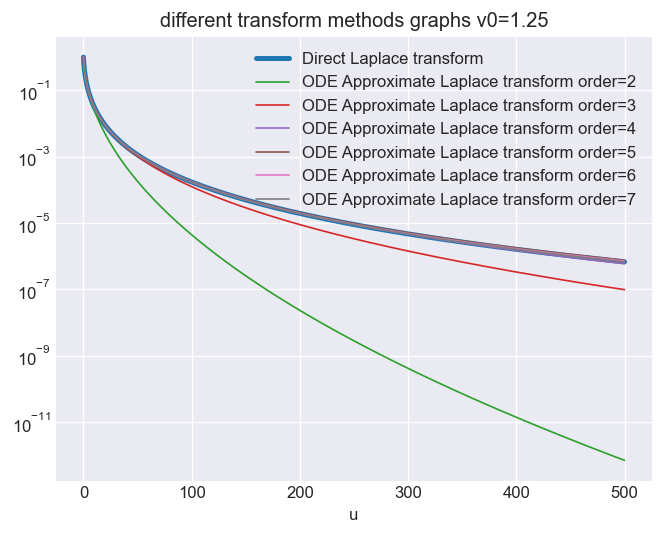

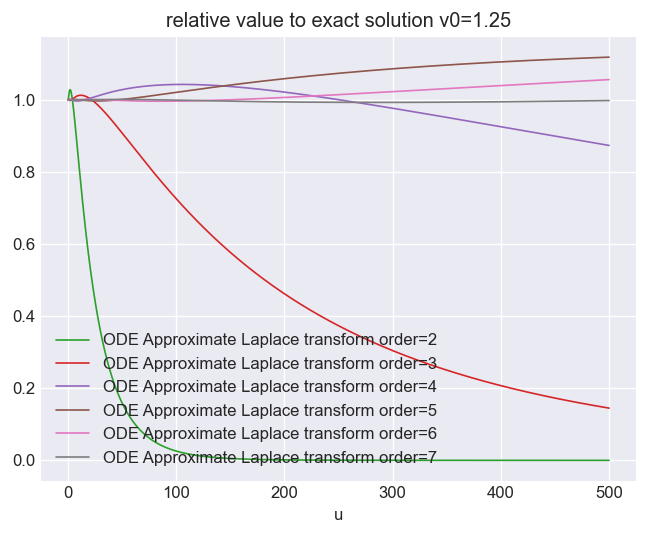

In [21]:
direct=LaplTrLNFastD(u_r,v0)
fig, ax = plt.subplots(dpi=120)
plt.title(f'different transform methods graphs v0={v0}')

plt.plot(u_r,direct, linewidth=3, color='C0', label=f'Direct Laplace transform')

for order in range(min_order,max_order+1):
    plt.plot(u_r,LaplTrLNApproximations[order](u_r,v0),linewidth=1, color=f'C{order}', 
             label=f'ODE Approximate Laplace transform order={order}')

plt.xlabel('u')
plt.yscale('log')
plt.legend(loc='upper right')
plt.show()

fig, ax = plt.subplots(dpi=120)
plt.title(f'relative value to exact solution v0={v0}')
for order in range(min_order,max_order+1):
    plt.plot(u_r,LaplTrLNApproximations[order](u_r,v0)/direct,linewidth=1, color=f'C{order}', 
             label=f'ODE Approximate Laplace transform order={order}')

plt.xlabel('u')
plt.legend(loc='lower left')
plt.show()